# 1. Introduction

The objective of this project is to perform statistical and spectral analysis of wave elevation time-series by analyzing a sample of the heave movements of a buoy deployed along the coast of Rio Grande do Sul, Brazil. This report describes procedures and equations used to arrive at results to the problems set out in the project specifications, always discussing them in the light of applied physical-mathematical modeling discussed in class.

# 2. Dataset

The chosen sample contains data for the 31st of August 2009, measured at latitude -31,56667 and longitude -49.86667, located close to the city of Tavares, as shown in the figure below:

<br />
<img src="images/BuoyLatLong.png" alt="Latitude and Longitude of Buoy" width="600" />
<br />

The sample data is stored in a file with a .tsr extension named "W200908311900", with each line providing, for an instant in time (first column), corresponding data of "heave", "etaEW" and "etaNS" (second, third and fourth columns, respectively). The figure below contains a screenshot of the initial part of the sample:

<br />
<img src="images/SampleExample.png" alt="Sample Example" width="400" />
<br />

It appears from the data that the sampling interval is of 0.78 seconds, which corresponds to a frequency of 1.28 hertz. To facilitate data manipulation throughout this report, we convert data from the Sample.tsc file to a python array:

In [1]:
def getPythonSampleArray():
    '''Open a sample file with data in columns and returns a python array with the data'''
    SampleFile = open("W200908311900.tsr", "r")
    # We get all the lines of the Sample file, except the first three because they contain headers
    unformattedLines = SampleFile.readlines()[3:]
    
    def formatLine(line):
        '''Lines come as a string with the following format "   0.8\t  0.800\t   0.410000\t   0.470000\n". 
        This function convert this string into an array like [0.8, 0.8, 0.41, 0.47], where each number
        element in the array corresponds to a n time, heave, etaEW and etaNS, respectively'''
        return list(map(float, line.split()))

    return list(map(formatLine, unformattedLines))

pythonSampleArray = getPythonSampleArray()

Then we stratify the sample into arrays containing relevant data (times, heaves) to be used throughout the report:

In [2]:
def getTimesAndHeavesFromSample():
    '''Get data from sample and returns two arrays, with times and heaves'''
    # Loop through data inside the sample and get times and heaves only
    times, heaves = [], []
    for row in pythonSampleArray:
        time, heave = row[0], row[1]
        times.append(time)
        heaves.append(heave)
    return times, heaves

times, heaves = getTimesAndHeavesFromSample()

We then install the following packages: 

1. Numpy, to help us make certain array operations faster and easier;
2. MatPlotLib, to help us plot data;
3. Scipy, to provide us algorithms for running data analysis; and
4. Stats Models, to calculate the autocorrelation function using a Fast Fourier Transform;

If any error indicating the need to install these packages occurs when running this notebook, uncomment the cell below and run it to install them.

In [3]:
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scipy
# ! pip install statsmodels

We import the mentioned packages as officially advised and adopted by the community and import other python native packages. All of them are then available for use in the next cells of this report.

In [4]:
# Community packages
import numpy as np
import matplotlib.pyplot as plt

# Native packages
import math

(since all of the interesting functions in Scipy and Stats Models are located in submodules, their algorithms are imported as needed in corresponding cells) 

To get a visual sense of the waves behaviour, we plot a graph of the heave against time for the entire and a subset of the time interval (the first 16 seconds):

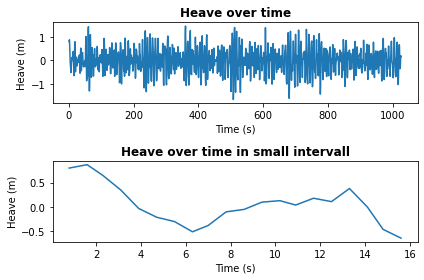

In [5]:
def plotHeavesVisualization():
    '''Plot two graphs with heaves over entire time interval and in a small interval'''
    # We create a figure made of 2 different plots
    fig, ax = plt.subplots(2)

    ax[0].plot(times, heaves) # We put all time values on x axis and heave values on y axis of the first plot
    ax[0].set_title("Heave over time", fontweight ="bold")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Heave (m)")

    smallTimeInterval, smallHeaveInterval = times[0:20], heaves[0:20] # In the second plot, we analyse a smaller interval
    ax[1].plot(smallTimeInterval, smallHeaveInterval)
    ax[1].set_title("Heave over time in small intervall", fontweight ="bold")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Heave (m)")

    plt.tight_layout() # This ensures that plots do not overlap
    plt.show() # Command to effectively show plots

plotHeavesVisualization()

From where it can be seen that the heave movement seems to have a random character, which will be addressed throughout the report.

# 3. Part One - Analysis of Individual Waves

## 3.1 Mean, dispersion (variance), skewness, and kurtosis (first four moments)

In mathematics, the moments of a function are quantitative measures related to the shape of the function's graph. If the function is a probability distribution (as we expect in our analysis of individual waves), then the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis. Calculating these moments, it is possible to gain insights into whether the data obtained is compatible with what is expected. The formulas for each of these moments is presented below:


**Mean**
<br />
$x = \frac{1}{N} \sum_{i=1}^{N} x_i$

**Variance**
<br />
$σ = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - x)^2$

**Skewness**
<br />
$S = \frac{1}{N} \sum_{i=1}^{N} \frac {(x_i - x)^3}{σ}$

**Kurtosis**
<br />
$K = \frac{1}{N} \sum_{i=1}^{N} \frac {(x_i - x)^4}{σ}$

Using these definitions, we can calculate the four probabilistic moments for the heaves (time moments are not relevant to our analysis):

In [6]:
from scipy.stats import skew, kurtosis

# Using numpy and scipy to calculate relevant probabilistic moments for heave
heaveMean = np.mean(heaves)
heaveVariance = np.var(heaves)
heaveSkewness = skew(heaves)
heaveKurtosis = kurtosis(heaves, fisher=False) # fisher=False means it is not the extreme kurtosis

# We also make the heave standard deviation avaliable throughout the report
heaveStandardDeviation = np.sqrt(heaveVariance)

And present them in a table:

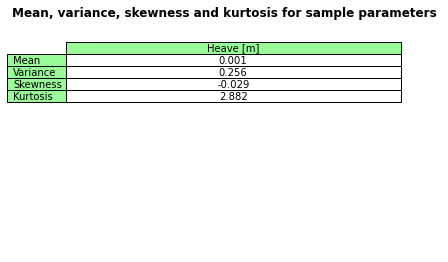

In [7]:
def plotHeaveProbabilisticMomentsTable():
    '''Plots a table with the heaves first four probabilist moments'''
    # So that we can loop easily through moments
    heaveMoments = [heaveMean, heaveVariance, heaveSkewness, heaveKurtosis]
    
    rowLabels = ["Mean", "Variance", "Skewness", "Kurtosis"] # Labels in row headers
    plt.table(
        # Data
        colLabels=[f"Heave [m]"], # Labels in column headers
        rowLabels=rowLabels, 
        cellText=[[round(moment, 3)] for moment in heaveMoments], # We round the moments to be more presentable
        # Styles
        rowColours=["palegreen"] * len(rowLabels), # Color of row headers
        colColours=["palegreen"], # Color of column headers
        cellLoc="center", # Position of data in table cell
        loc="upper left") # Position of table in Jupyther cell    
    
    plt.axis("off") # As we don't want to show x-axis and y-axis in a table
    plt.title("Mean, variance, skewness and kurtosis for sample parameters \n", fontweight ="bold") # \n means we jump a line
    plt.show() 
    
plotHeaveProbabilisticMomentsTable()

From this sample, it can be inferred that the mean and skewness values are sufficiently close to zero, so that 
subsequent assumptions in the report for obtaining analytical short-terms probabilistic distributions of the wave characteristics are met. Knowing that the kurtosis of the normal distribution (which will be used later) is 3, it appears that the obtained value (2.882) is also compatible with what is expected, validating the sample for subsequent analysis.

## 3.2 Distribution of Free Surface Elevation
(in comparison with Gaussian and Longuet-Higgins distributions)

Here we treat the generation of waves as a random process, whose randomness follows from the nature of the generating forces and is a consequence of various instabilities in the wave evolution process. If we assume that the wave is a composition of denumerably many independent harmonic components, then by the central-limit theorem the distribution of free-surface elevation (and by extension the heave movement of analysed buoy) becomes Gaussian. In the case of weak nonlinear interactions a certain deviation from the Gaussian distribution may appear, as shown theoretically by Longuet-Higgins (1963). The nonlinearity is then introduced by means of the third- and fourth-order normalized central moments, μ3 (skewness) and μ4 (extreme kurtosis), with the following coefficents:

$λ_3 = \frac {μ_3}{σ_n^3}$ <br />
$λ_4 = \frac {μ_4}{σ_n^4} -3$

Where $σ_n$ is the standard deviation, γ3 is the coefficient of skewness, a measure of the increasing vertical asymmetry in the wave profile due to second-order nonlinear interactions, and γ4 the coefficient of kurtosis, which reflects the total increase of the crest-to-trough wave height due to third-order nonlinear interactions. Considering that the wave profiles have Gaussian distribution with zero-mean and unit variance, we get that $λ_3 = μ_3 =$ skewness, $λ_4 = μ_4 - 3 =$ kurtosis. Then the Longuet-Higgins distributions gets the follow equation:


$f(x) = \frac {1}{σ \sqrt{2\pi}} e^{\frac {-x^2}{2}} [1 + \frac{λ_3 H_3(x)}{3!} + \frac{λ_4 H_4(x)}{4!} + \frac{10 λ_3^2 H_6(x)}{6!} +  ...]$

Where, for the heave sample, σ is the standard deviation and $x = \frac {heave}{σ}$

For $H_n$ being the Hermite polynomials, given, negleting terms with high denominators, by: <br />
$H_3 = x^3 - 3x$ <br />
$H_4 = x^4 - 6x^2 + 3$ <br />
$H_6 = x^6 - 15x^4 + 45x^3 - 15$ <br />

To simplify the application of this formula in program, we can divide it into two terms: <br />
$NormalDistributionFactor(x) = \frac {1}{σ \sqrt{2\pi}} e^{\frac {-x^2}{2}}$ <br />
$MultiplyingFactor(x) = [1 + \frac{λ_3 H_3(x)}{3!} + \frac{λ_4 H_4(x)}{4!} + \frac{10 λ_3^2 H_6(x)}{6!}]$

Then: <br />
$f(x) = NormalDistributionFactor(x).MultiplyingFactor(x)$

We can calculate the value for the Longuet-Higgins distribution as:

In [8]:
from scipy.stats import norm

def longuetHigginsDensityDist(heaves, mean, standardDeviation, skewness, extremeKurtosis):
    '''Receives a list of heaves and the corresponding four probabilistc moments 
    (with the extreme kurtosis, which is kurtosis - 3). Returns a list of densities
    for the probabilistic distribution function'''
    def x(heave): return heave/standardDeviation
    def H3(x): return x**3 - 3*x 
    def H4(x): return x**4 - 6*(x**2) + 3
    def H6(x): return x**6 - 15*(x**4) + 45*(x**2) - 15
    
    def normalDistFactor(heave):
        '''Receives a heave and returns the normal distribution pdf
        value for that heave with mean and standard deviation as passed
        for the sample of heaves'''
        # More information about norm.pdf: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
        return norm.pdf(heave, loc=mean, scale=standardDeviation)
    
    lambda3, lambda4 = skewness, extremeKurtosis
    def multiplyingFactor(heave):
        '''Receives a heave and returns the multipying factor to the
        normal distribution value of the Longuet-Higgins distribution, 
        considering mean heave being zero'''
        # We consider the multiplying factor to be 1 + second term + third term + fourth term
        second = (lambda3/math.factorial(3))*H3(x(heave))
        third = (lambda4/math.factorial(4))*H4(x(heave))
        fourth = ((lambda3**2)/math.factorial(6))*10*H6(x(heave))
        return 1 + second + third + fourth
    
    def f(heave):
        return normalDistFactor(heave)*multiplyingFactor(heave)
    
    densities = [f(heave) for heave in heaves]
    return densities

We use empirical data of the heaves to construct a histogram and compare the results with Gaussian and Longuet-Higgins distributions (with the probabilistic moments of the data as inputs):

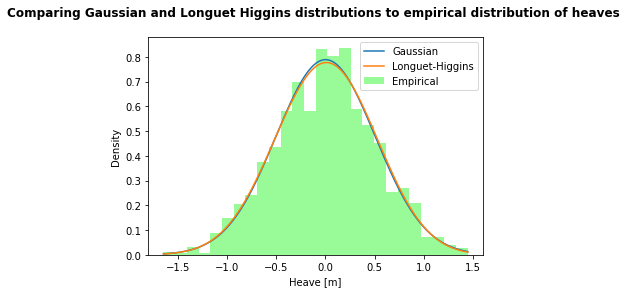

In [9]:
def compareDistributionsWithEmpiricalData():
    '''Using empirical heaves data (and corresponding probabilistic moments), plots a 
    graph comparing empirical with Gaussian and Longuet-Higgins distributions'''
    # Determining best bin fit for data. For more details, see:
    # https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
    # PS: "_" is commonly used in python as a placeholder for variables that are not going to be used,
    # but must be assigned to unpack other variables
    _, bins = np.histogram(heaves, bins="auto", density=True)

    # We are going to compare empirical obtained heaves with Gaussian and
    # Longuet-Higgins distributions (which are continuous functions). To make
    # them look continuous in plot, we generate a larger number of heave values
    # within the bin interval. 
    # This should be equivalent to np.linspace(min(heaves), max(heaves), num=1000)
    largeNumberOfHeaves = np.linspace(min(bins), max(bins), num=1000) 

    # Calculating densities of Gaussian and Longuet-Higgins distributions
    gaussianDensities = norm.pdf(largeNumberOfHeaves, loc=heaveMean, scale=heaveStandardDeviation)
    longuetHigginsDensities = longuetHigginsDensityDist(
        heaves=largeNumberOfHeaves, 
        mean=heaveMean,
        standardDeviation=heaveStandardDeviation, 
        skewness=heaveSkewness,
        extremeKurtosis=heaveKurtosis-3) # Extreme kurtosis is just kurtosis - 3

    # Ploting Gaussian, Longuet and empirical data in the same figure
    plt.plot(largeNumberOfHeaves, gaussianDensities, label="Gaussian")
    plt.plot(largeNumberOfHeaves, longuetHigginsDensities, label="Longuet-Higgins")
    plt.hist(heaves, bins=bins, density=True, color="palegreen", label="Empirical") 
    
    plt.legend(loc="best") # Optimal position for labels
    plt.title("Comparing Gaussian and Longuet Higgins distributions to empirical distribution of heaves \n", 
                 fontweight ="bold") 
    plt.xlabel("Heave [m]")
    plt.ylabel("Density")
    plt.show()
    
compareDistributionsWithEmpiricalData()

From the graph, it is possible to see that the distributions fit the data well and are quite similar - indicating that the effect of weak nonlinear wave interactions is negligible. This is somewhat expected, as the principal contribution to the asymmetry of the Longuet-Higgins distribution and the observed good fit with the heave data is the coefficient of skewness, which is quite low in our analysis.

## 3.3 Identify Up-crossing and Down-crossing individual waves and associated periods
Representing wave heights in a histogram and comparing with the Rayleigh distribution.

The standard method of determining the short-term statistics of a wave record is through the zero-crossing analysis. Either the so-called zero-upcrossing method or the zero-downcrossing method may be used; the obtained statistics should be the same for both methods when using a sufficiently long sample. 

For the zero-upcrossing method, the mean water level is first determined. The wave record is marked each time the water surface crosses the mean level in an upward direction. Individual waves are then identified between the upcrossings and the individual wave height, $H_i$, and wave period, $T_i$, are determined, where i is an index counter to identify each wave. An equivalent procedure is used to determine waves with the zero-downcrossing method, with the waves marked each time the water surface crosses the mean level in a downward direction.

We can mark the waves with the following procedure:
1. Detrend (a technique to remove unwanted trends from time-series data) heaves by subtracting each
   heave value by the mean heave;
2. Convert each obtained value to a signal (if the value is positive, it is converted to +1. If is
   negative, -1. And if is 0, it continues to be 0);
3. For each signal, get the difference between the current signal and the last signal.
    1. If the difference is 2, it means the current signal (and consequently heave) is **positive**
    and the last signal was **negative** (+1 - (-1) = 2). So we are dealing with an **up-crossing wave**;
    2. If the difference is -2, it means the current signal (and consequently heave) is **negative**
    and the last signal was **positive** (-1 - (+1) = -2). So we are dealing with a **down-crossing wave**;
4. Mark the indexes for each occurence of a zero-crossing wave in each case (up or down) and then use those 
   indexes to identify waves and extract relevant wave statistics.

Because we are going to detrent heave data in part two as well, we make the detrended heave data avaliable throughout the report, ensuring that the detrending technique (i.e, subtracting each heave value by the mean) is the same in both parts:

In [10]:
detrendedHeaves = np.asarray(heaves) - np.mean(heaves)

In [11]:
def getHeavesCrossingIndexes():
    '''Assuming heave data is already detrended (step 1), apply the algorithm of: 
    2) Convert detrended heave values to signals
    3) Compute the difference between current and last obtained signals
    4) Find and return up and down-crossing indexes'''

    # 2: We convert those heaves with the mean subtracted to signals
    # that is, it returns -1 if heave < 0, 0 if heave==0, 1 if heave > 0 
    # https://numpy.org/doc/stable/reference/generated/numpy.sign.html?highlight=sign#numpy.sign
    signals = np.sign(detrendedHeaves)

    # 3: We compute the difference between current and last signals, that is, for i being an
    # index, diff[i] = signal[i+1] - signal[i]
    # https://numpy.org/doc/stable/reference/generated/numpy.diff.html
    diffs = np.diff(signals)

    # 3A and 3B: We then find the indexes of values in diffs. If the difference between two
    # consecutive signals were equal to 2, it means it is an up crossing, and if it is equal to
    # - 2, it is a down crossing.
    # https://numpy.org/doc/stable/reference/generated/numpy.where.html?highlight=where#numpy.where
    upCrossingIndexes = np.where(diffs == 2)[0]
    downCrossingIndexes = np.where(diffs == -2)[0]
    return upCrossingIndexes, downCrossingIndexes

upCrossingIndexes, downCrossingIndexes = getHeavesCrossingIndexes()

def getWaves(crossingIndexes):
    '''Receives the indexes of a zero-crossing analysis and
    returns a list of waves, each wave containing its number 
    (from the order it appears), height, period and order 
    (rank of height, ie, the biggest wave will be 1, the second
    biggest 2, and so on)'''
    waves, lastIndex = [], crossingIndexes[0]
    for n, currentIndex in enumerate(crossingIndexes[1:]):
        waveHeaves = heaves[lastIndex:currentIndex]
        wave = { "number": n + 1, 
                 "height": max(waveHeaves) + np.abs(min(waveHeaves)), 
                 "period": times[currentIndex] - times[lastIndex] }
        waves.append(wave)
        lastIndex = currentIndex
    
    def getOrders():
        '''Easyest way to rank an array. See:
        https://codereview.stackexchange.com/questions/65031/creating-a-list-containing-the-rank-of-the-elements-in-the-original-list'''
        heights = [wave["height"] for wave in waves]
        orders = [0] * len(heights)    
        for i, x in enumerate(sorted(range(len(heights)), key=lambda y: heights[y], reverse=True)):
            orders[x] = i + 1
        return orders
    
    # Appending orders to each wave
    orders = getOrders()
    for i, wave in enumerate(waves):
        wave["order"] = orders[i]
    return waves

upCrossingWaves = getWaves(upCrossingIndexes)
downCrossingWaves = getWaves(downCrossingIndexes)

In [12]:
def plotWavesTable(waves, direction):
    '''Receives a list of waves and the corresponding crossing analysis direction
    and plots a table with corresponding wave numbers, heights, periods and orders'''
    colLabels = ["Wave Number", "Wave Height H(m)", "Wave Period T(s)", "Order Number"]
    table = plt.table(
        colLabels=colLabels,
        cellText=[[round(val, 3) for val in wave.values()] for wave in waves],
        colColours=["palegreen"] * len(colLabels), 
        cellLoc="center",  
        loc="center")   
    table.auto_set_font_size(False) # Making sure we can mannually set the fonsize
    table.scale(1.6, 1.1) # Make the table bigger horizontally and vertically
    table.set_fontsize(14)
    
    plt.axis("off")
    plt.title(f"Wave Numbers, Heights, Periods and Orders from a zero-{direction}crossing analysis \n", 
              fontweight ="bold", fontsize=14) 
    plt.show()

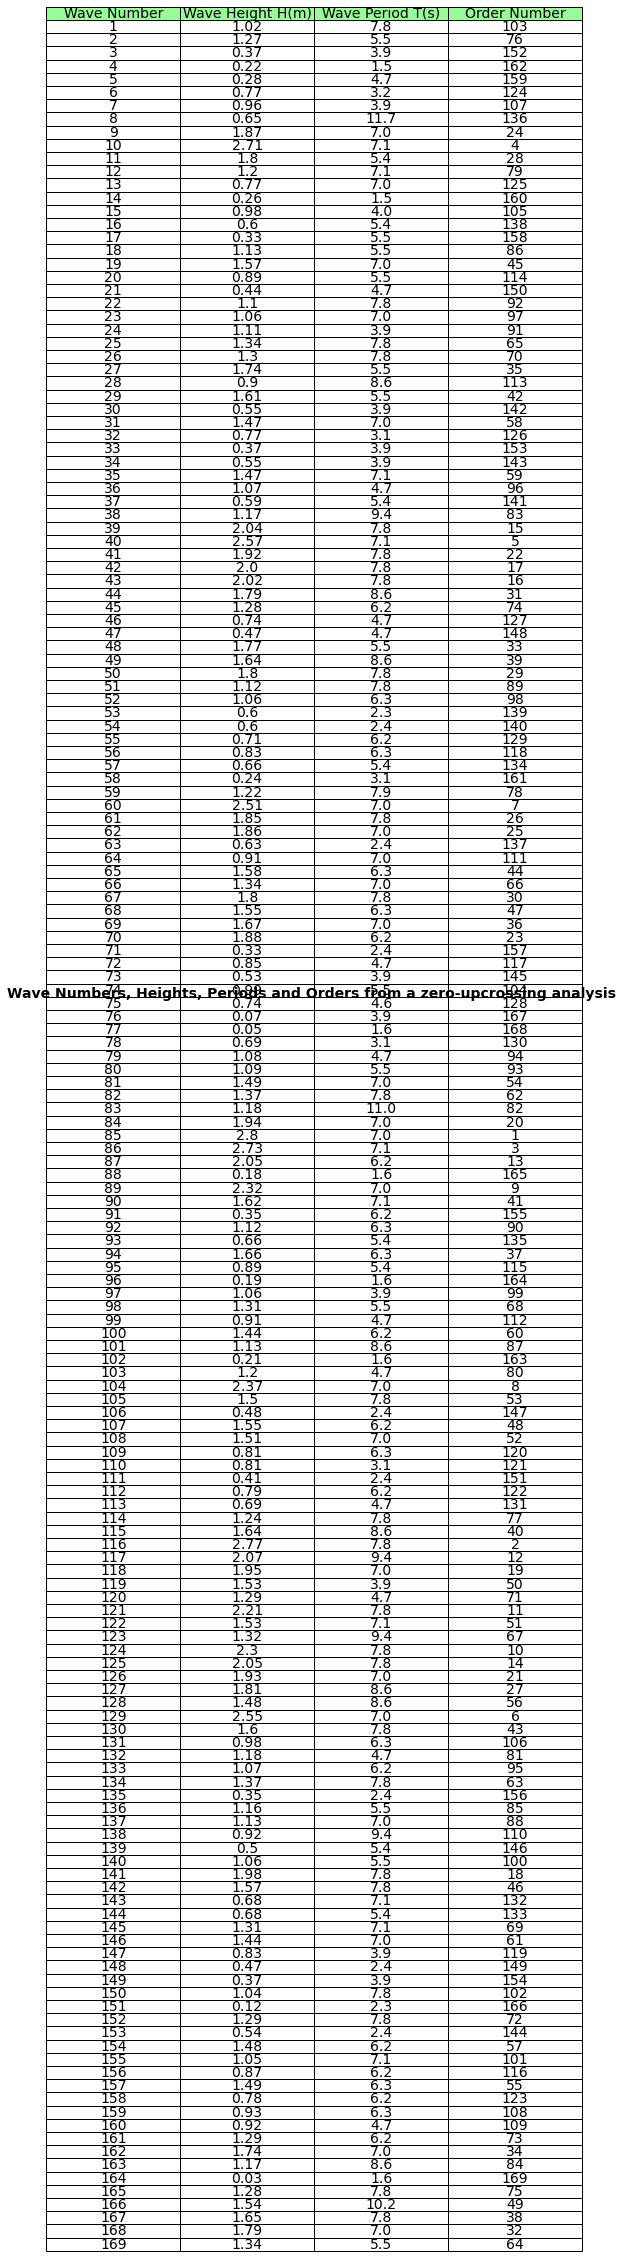

In [13]:
plotWavesTable(upCrossingWaves, direction="up")

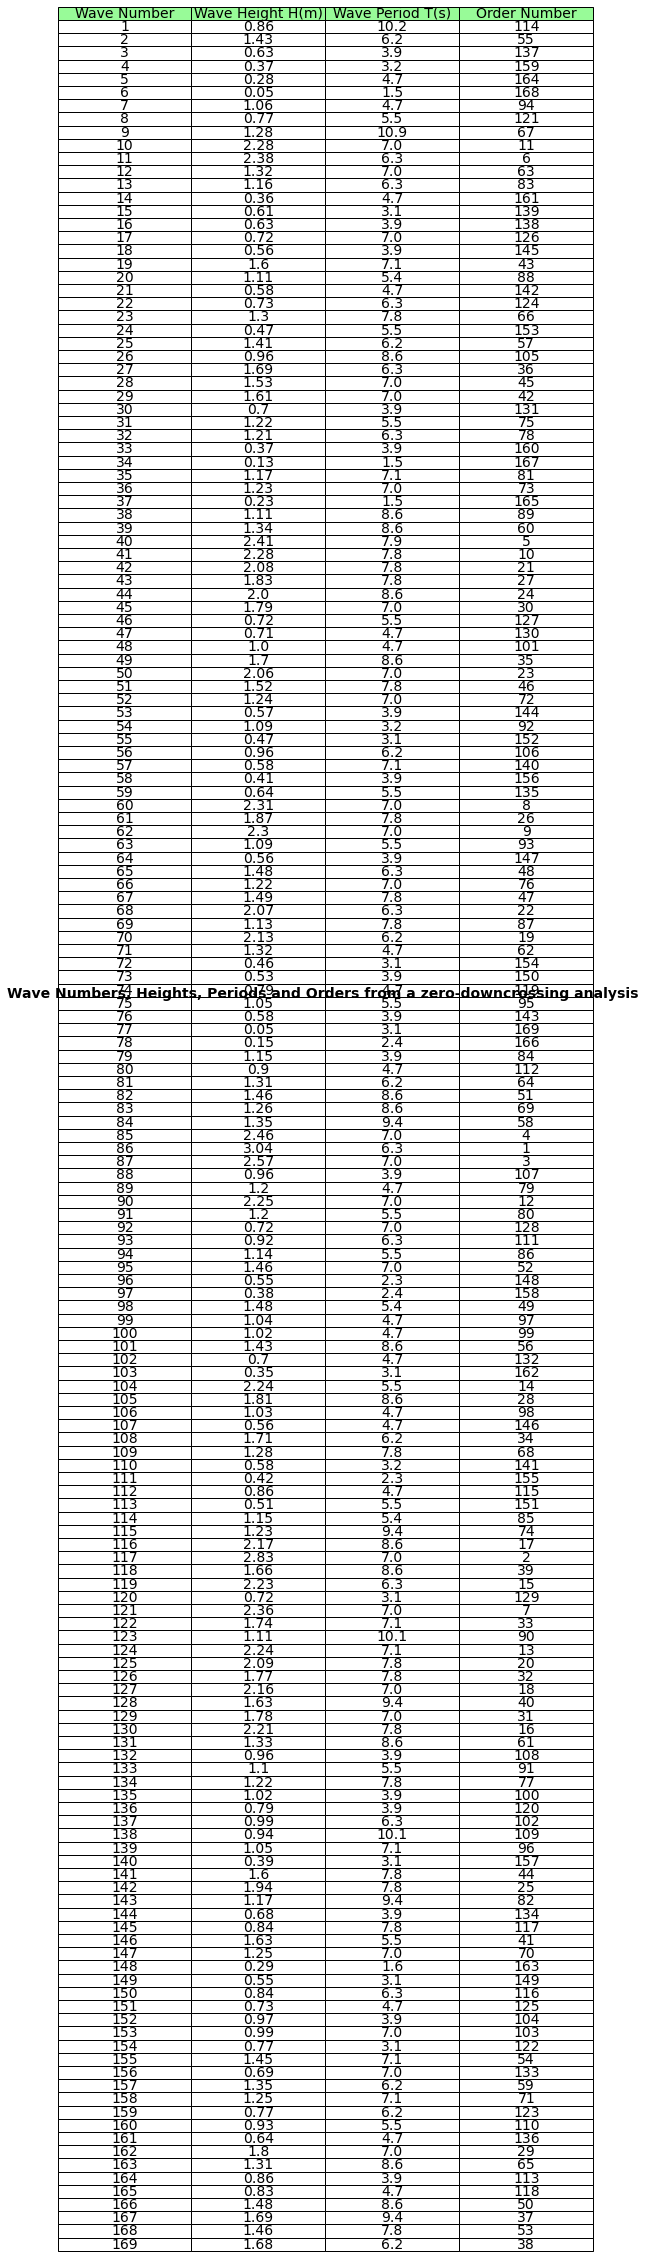

In [14]:
plotWavesTable(downCrossingWaves, direction="down")

In [15]:
def getWavesStatistics(waves):
    '''Receives a list of waves and returns its mean height, maximum height,
    the period corresponding to the maximum height wave and the number of waves'''
    heights, periods = [], []
    for wave in waves:
        heights.append(wave["height"])
        periods.append(wave["period"])
    
    meanHeight = np.mean(heights)
    maxHeight = np.amax(heights)
    maxHeightIndex = np.where(heights == maxHeight)[0][0]
    maxHeightPeriod = periods[maxHeightIndex]
    numberOfWaves = len(waves)
    
    return { "meanHeight": round(meanHeight, 6), "maxHeight": round(maxHeight, 6),
             "maxHeightPeriod": round(maxHeightPeriod, 6), "numberOfWaves": numberOfWaves }
        
# We get the statistics for both up and down-crossing waves
upCrossingStats = getWavesStatistics(upCrossingWaves)
downCrossingStats = getWavesStatistics(downCrossingWaves)

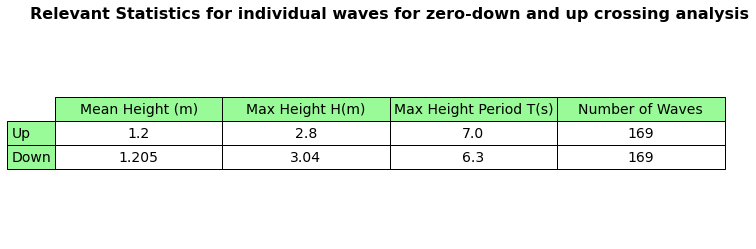

In [16]:
def plotWavesStatsTable(upCrossingStats, downCrossingStats):
    '''Receives statistics from up and downcrossing waves and
    plots a table showing these statistics'''
    colLabels = ["Mean Height (m)", "Max Height H(m)", "Max Height Period T(s)", "Number of Waves"]
    rowLabels = ["Up", "Down"]
    table = plt.table(
        colLabels=colLabels,
        rowLabels=rowLabels,
        cellText=[[round(val, 3) for val in stats.values()] for stats in [upCrossingStats, downCrossingStats]],
        colColours=["palegreen"] * len(colLabels),
        rowColours=["palegreen"] * len(rowLabels), 
        cellLoc="center",  
        loc="center")         
    table.auto_set_font_size(False) 
    table.scale(2, 2) 
    table.set_fontsize(14)
    
    plt.axis("off")
    plt.title("Relevant Statistics for individual waves for zero-down and up crossing analysis", 
              fontweight ="bold", fontsize=16) 
    plt.show()
    
plotWavesStatsTable(upCrossingStats, downCrossingStats)

From the table above, we can see that we get the same number of waves for both methods, and the maximum wave height and the wave period associated with the wave with maximum height is the same up to 3 digits. Although the mean height obtained by the two methods is different, the percentual discrepancy between the values obtained is approximately 3.1%, which is acceptable since, as mentioned before, the statistics obtained by the two methods is not necessarily equal, but simply must be more and more similar as the sample size increases.

We also know that, theoretically, random wave heights (and by extension, heaves), follow the Rayleigh Probability Distribution, which can be mathematically expressed in several different forms. Using the mean heave $H_{mean}$ as reference and $H$ as a heave, this distribution may be expressed as:

$f(H) = \frac{\pi H}{2 H_{mean}^2} e^\frac{-\pi H^2}{4 H_{mean}^2}$

Which can be obtained as:

In [17]:
def rayleighDensityDist(heights):
    '''Receives a list of wave heights and returns a list of densities
    for the rayleigh probabilistic distribution function'''
    meanHeightSquared = np.mean(heights)**2
    def multiplyingFactor(H):
        return (np.pi*H) / (2*meanHeightSquared)
    
    def exponentialFactor(H):
        numerator = -np.pi*(H**2)
        denominator = 4*meanHeightSquared
        return np.exp(numerator/denominator)
    
    def f(H):
        return multiplyingFactor(H)*exponentialFactor(H)
    
    densities = [f(H) for H in heights]
    return densities

As we are going to check if the Raylegh distribution matches the histogram of wave heights obtained by both zero down and up-crossing methods, we create a function to make a plot with the comparison having the list of heights as an input:

In [18]:
def plotRayleighComparison(waveHeights, direction):
    '''Receives a list of wave heights and a direction (up or down)
    and plots an histogram of wave heights with a corresponding
    expected Rayleigh distribution'''
    # Determining best bin fit for wave heights in histogram
    _, bins = np.histogram(waveHeights, bins="auto", density=True)
    
    # We are going to compare empirical obtained wave heights with the expected
    # Rayleigh distribution (which is a continuous function). To make it look
    # continuous in plot, we generate a larger number of wave heights values
    # within the bin interval. 
    # This should be equivalent to np.linspace(min(waveHeights), max(waveHeights), num=1000)
    largeNumberOfWavesHeights = np.linspace(min(bins), max(bins), num=1000)
    rayleighDensities = rayleighDensityDist(largeNumberOfWavesHeights) 
    
    # Ploting Rayleigh distribution and empirical data in the same figure
    plt.plot(largeNumberOfWavesHeights, rayleighDensities, label="Rayleigh")
    plt.hist(waveHeights, bins=bins, density=True, color="palegreen", label="Empirical")
    plt.legend(loc="best")
    plt.title(f'''Comparing Rayleigh distribution to empirical distribution of Wave Heights
        for zero-{direction} crossing analysis \n''', fontweight ="bold")
    plt.xlabel("Wave Height H(m)")
    plt.ylabel("Density")
    plt.show()

So we make the comparison for wave heights obtained with the zero up-crossing method:

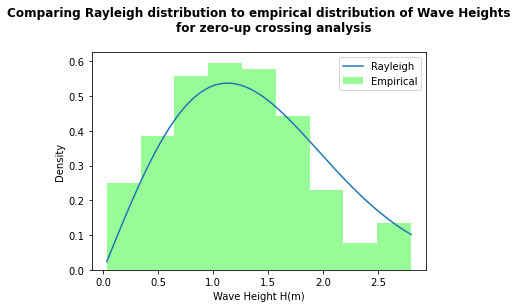

In [19]:
upCrossingWaveHeights = [wave["height"] for wave in upCrossingWaves]
plotRayleighComparison(upCrossingWaveHeights, direction="up")

And for wave heights obtained with the zero down-crossing method we have:

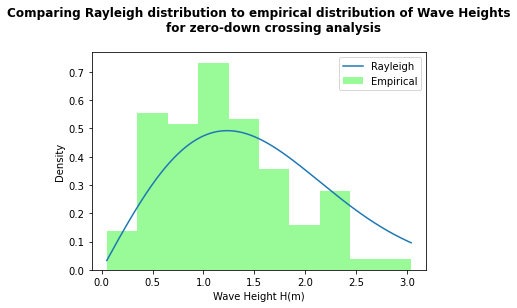

In [20]:
downCrossingWaveHeights = [wave["height"] for wave in downCrossingWaves]
plotRayleighComparison(downCrossingWaveHeights, direction="down")

Analyzing both graphs, it appears that the Rayleigh distribution represents the wave height distribution accurately enough for both methods.

## 3.4 Significant wave height and significant wave period.
(and comparison of significant wave height to mean wave height and maximum wave height)

The most widely used statistical wave height for a short term wave record is the so-called significant height, denoted as $H_s$. The significant wave height is defined as the mean of the largest one-third of the waves in the wave record. Because we already did rank ordered wave heights, we can easily calculate the significant wave height by considering the average of the top one-third (${N/3}$) with the formulas below: 

**Significant Wave Height**
<br />
$H_s = \frac{1}{N/3} \sum_{i=1}^{N/3} H_i$

Similarly, for the significant period we have:


**Significant Period**
<br />
$T_s = \frac{1}{N/3} \sum_{i=1}^{N/3} T_i$

By calculating those values, we get:

In [21]:
def getWavesSignificantStatistics(waves, direction):
    '''Receives a list of waves and a direction (up or down) and
    returns an array containing the significant height and significant
    period, respectively'''
    topThird =int(round(len(waves)/3))
    sHeightSum, sPeriodSum = 0, 0
    for wave in waves:
        order = wave["order"]
        if order <= topThird:
            sHeightSum += wave["height"]
            sPeriodSum += wave["period"]
    
    significantHeight = sHeightSum / topThird
    significantPeriod = sPeriodSum / topThird
    
    print(f"Significant Height for zero-{direction} crossing method: {significantHeight}")
    print(f"Significant Period for zero-{direction} crossing method: {significantPeriod} \n")
    return { "significantHeight": significantHeight, "significantPeriod": significantPeriod }

upCrossingSignificantStats = getWavesSignificantStatistics(upCrossingWaves, direction="up")
downCrossingSignificantStats = getWavesSignificantStatistics(downCrossingWaves, direction="down")

Significant Height for zero-up crossing method: 1.8976785714285709
Significant Period for zero-up crossing method: 7.223214285714287 

Significant Height for zero-down crossing method: 1.9169642857142848
Significant Period for zero-down crossing method: 7.29464285714286 



Then we can compare significant height with average and maximum heights:

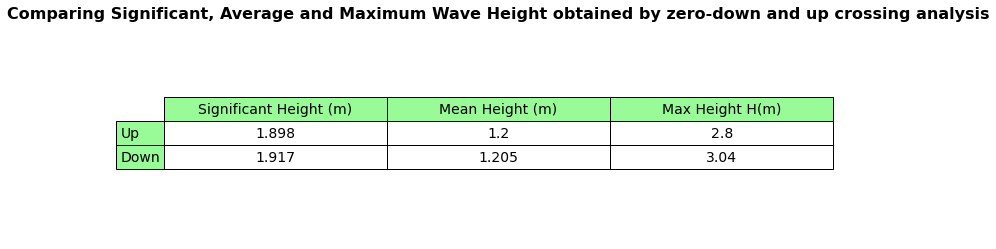

In [22]:
# Unifing up-crossing heights
upCrossingHeights = [upCrossingSignificantStats["significantHeight"],
                          upCrossingStats["meanHeight"],
                          upCrossingStats["maxHeight"]]

# Unifing down-crossing heights
downCrossingHeights = [downCrossingSignificantStats["significantHeight"],
                          downCrossingStats["meanHeight"],
                          downCrossingStats["maxHeight"]]


def plotHeightsComparison(upHeights, downHeights):
    '''Receives up and downcrossing heights and plots
    a table comparing them'''
    colLabels = ["Significant Height (m)", "Mean Height (m)", "Max Height H(m)"]
    rowLabels = ["Up", "Down"]
    table = plt.table(
        colLabels = colLabels,
        rowLabels = rowLabels,
        cellText = [[round(h, 3) for h in heights] for heights in [upHeights, downHeights]],
        colColours =["palegreen"] * len(colLabels), 
        rowColours =["palegreen"] * len(rowLabels), 
        cellLoc ="center",  
        loc ="center")
    table.auto_set_font_size(False)
    table.scale(2, 2) 
    table.set_fontsize(14)
    
    plt.axis("off")
    plt.title("Comparing Significant, Average and Maximum Wave Height obtained by zero-down and up crossing analysis",
                 fontweight ="bold", fontsize=16) 
    plt.show()


plotHeightsComparison(upCrossingHeights, downCrossingHeights)

We can see in the table above that all values are sufficently close for the zero up and down-crossing methods, with a precision expected for the sample size used. The maximum wave height is approximately 1.5 times the size of the significant wave height, which in turn is approximately 1.61 the size of the mean wave height for both methods. One interesting feature of the significant wave height is that it is thought to correspond to the wave conditions that would be estimated visually by an observer looking at a random sea. In other words, the human eye has a natural filtering that tends to exclude the smallest waves and focus instead on the larger waves in the sea state. For design purposes of coastal engineering structures, however, a careful analysis must be done not only using the significant height, but using the Rayleigh distribution to estimate the probability of waves larger than a threshold value where the structure would break.


# 4. Part Two - Spectral Analysis

The second part of this project focuses on analyzing the behavior of heaves in the frequency domain. As mentioned before, the waves of the sea are assumed to be a composition of denumerably many independent harmonic waves, each with a characteristic frequency and amplitude.

## 4.1 Autocorrelation function from time series

--


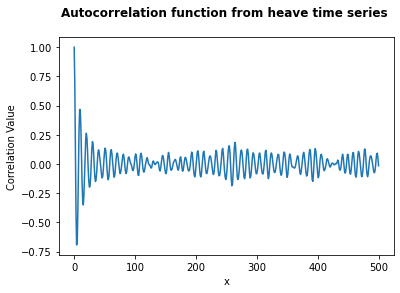

In [23]:
from statsmodels.tsa.stattools import acf

def plotAutocorrelationFunction():
    '''From heaves time series, uses FFT to compute and plot the autocorrelation function
    See: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html?highlight=acf'''
    correlationValues = acf(
        heaves, 
        nlags=500, # Number of lags 
        fft=True # If uses FFT to calculate the autocorrelation function
    )
    xs = np.linspace(0, len(correlationValues)-1, num=len(correlationValues))

    plt.plot(xs, correlationValues)
    plt.title("Autocorrelation function from heave time series \n", fontweight="bold")
    plt.xlabel("x")
    plt.ylabel("Correlation Value")
    plt.show()
    
plotAutocorrelationFunction()

## 4.2 Power Spectrum from FFT

--


We make the sampling interval dt avaliable for use in next cells:

In [24]:
# dt is the sampling interval
dt = 0.78

# We assert that the hard coded value in the last cell is vaguely close to the sampling interval
# obtained from the actual sample
assert(np.isclose(times[1] - times[0], dt, atol=0.2))

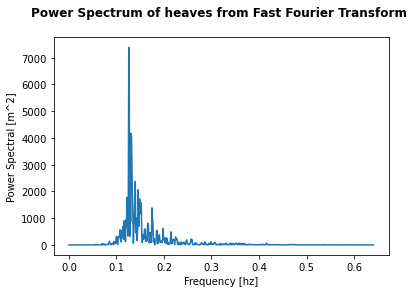

In [25]:
def plotPowerSpectrumFromFFT():
    '''Using Numpy to plot the Power Spectrum of the heaves, 
    assuming heave data is already detrended.
    Also, we window heave values before applying the Discrete Fourier Transform (DFT)'''
    # Apply a Hanning window to avoid spectral leakage
    window = np.hanning(len(detrendedHeaves))*detrendedHeaves

    # Calculate the power spectrum
    powerSpectrum = np.abs(np.fft.rfft(window))**2
    fs = np.fft.rfftfreq(len(window), dt) # frequencies

    # We sort the obtained frequencies and find its indexes
    idx = np.argsort(fs)

    # And plot the Power Spectrum against frequencies in the corret order
    plt.plot(fs[idx], powerSpectrum[idx])
    plt.title("Power Spectrum of heaves from Fast Fourier Transform \n", fontweight="bold")
    plt.xlabel("Frequency [hz]")
    plt.ylabel("Power Spectral [m^2]")
    plt.show()
    
plotPowerSpectrumFromFFT()

## 4.3 Noise Reduction with Daniell's, Bartlett and Welch’s methods

--


### B) Bartlett's Method

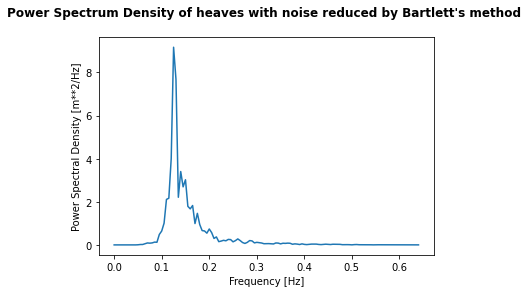

In [26]:
from scipy import signal

def welchSpectrum(noverlap, nperseg):
    '''Calculate Power Spectral Densitites with Welch's method from 
    given number of points to overlap between segments (noverlap) and 
    lenght of each periodogram (nperseg). Returns an array with frequencies
    and PSDs. We are using scipy.signal.welch, more info avaliable on: 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html'''
    return signal.welch(
        heaves, 
        detrend="constant", # Detrend each heave by subtracting the heave mean, as we did for time-series
        window="hanning", # Apply a Hanning window before taking the Discrete Fourrier Transform (DFT)
        fs=(1 / dt), # Sample rate
        scaling="density", # Compute the power spectral density
        noverlap=noverlap, # Number of points to overlap between segments
        nperseg=nperseg # Lenght of each periodogram
        )

def plotBartlettPSD():
    '''Plot the Power Spectrum Density, computed using Bartlett's method'''
    def bartlettSpectrum(): 
        '''If there's no overlap, i.e, noverlap is 0, Welch's method is 
        equivalent to Bartlett’s method '''
        return welchSpectrum(noverlap=0, nperseg=None)
    
    # fsBarlett are frequencies in hertz and PSD power spectral densities in meters squared/hertz
    fsBartlett, PSDBartlett = bartlettSpectrum()
    plt.plot(fsBartlett, PSDBartlett)
    plt.title("Power Spectrum Density of heaves with noise reduced by Bartlett's method \n", fontweight="bold")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power Spectral Density [m**2/Hz]")
    plt.show()
    
plotBartlettPSD()

### C) Welch's Method

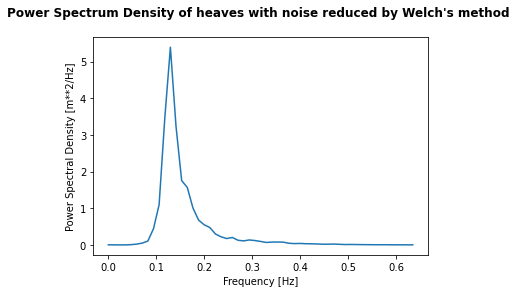

In [73]:
# We compute the Power Spectral Densities using welch's method
numberOfDegreesOfFreedom = 24
numberOfWindows = len(heaves) / (numberOfDegreesOfFreedom / 2)
fsWelch, PSDWelch = welchSpectrum(nperseg=numberOfWindows, noverlap=numberOfWindows//2) 

def plotWelchPSD():
    '''Plot the Power Spectrum Density from computed values'''
    plt.plot(fsWelch, PSDWelch)
    plt.title("Power Spectrum Density of heaves with noise reduced by Welch's method \n", fontweight="bold")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power Spectral Density [m**2/Hz]")    
    plt.show()
    
plotWelchPSD()

## 4.4 Spectral Parameters

--


### A) First 4 Spectral Moments

In [74]:
deltaT = len(heaves)*dt
bandwidth = (1 / deltaT) # Bandwidth of each band, in hertz

m0 = sum(PSDWelch)*bandwidth
m1 = sum(fsWelch*PSDWelch)*bandwidth
m2 = sum((fsWelch**2)*PSDWelch)*bandwidth
m3 = sum((fsWelch**3)*PSDWelch)*bandwidth

spectralParameters = [m0, m1, m2, m3]

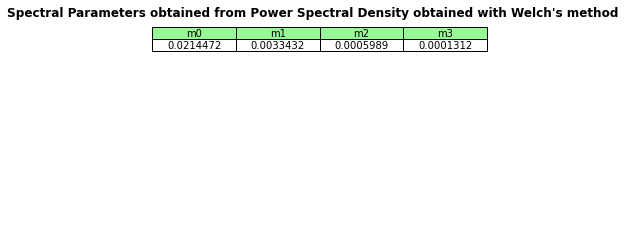

In [75]:
def plotSpectralParametersTable(spectralParameters):
    '''Receives a list of spectral parameters and plot a table with them'''
    colLabels = ["m0", "m1", "m2", "m3"]
    plt.table(
        colLabels = colLabels,
        cellText = [[round(param, 7) for param in spectralParameters]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="upper left")
    
    plt.axis("off")
    plt.title("Spectral Parameters obtained from Power Spectral Density obtained with Welch's method",
                 fontweight ="bold") 
    plt.show()


plotSpectralParametersTable(spectralParameters)

### B) Spectral Bandwidth Coefficient

In [76]:
spectralBandwidthCoeff = (m0 * m2 - m1**2) / m1**2

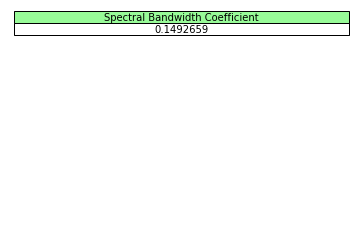

In [77]:
def plotSpectralBandwidthCoeffTable(coeff):
    '''Receives the spectral bandwidth coeff and plot a table with it'''
    colLabels = ["Spectral Bandwidth Coefficient"]
    plt.table(
        colLabels = colLabels,
        cellText = [[round(coeff, 7)]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="upper left")
    
    plt.axis("off")
    plt.show()

plotSpectralBandwidthCoeffTable(spectralBandwidthCoeff)

### C) Peak Period and Significant Wave Height

In [78]:
peakSpecIndex = np.argmax(PSDWelch) # Peak of the Power Spectral Density
Fp = fsWelch[peakSpecIndex] # Corresponding peak frequency in hertz

Tp = 1 / Fp # Peak period in seconds
Hs = 4 * np.sqrt(m0) # Significant Height in meters

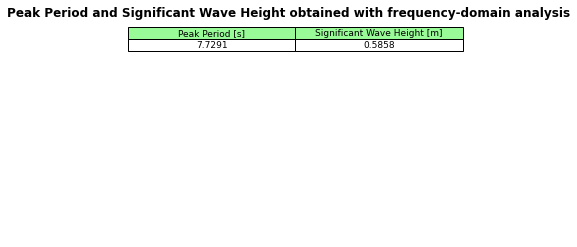

In [79]:
def plotPeakPeriodAndSignificantHeightTable(peakPeriod, significantHeight):
    '''Receives the peak period and significant height and plot a table with them'''
    colLabels = ["Peak Period [s]", "Significant Wave Height [m]"]
    plt.table(
        colLabels = colLabels,
        cellText = [[round(value, 4) for value in [peakPeriod, significantHeight]]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="upper left")
    
    plt.title("Peak Period and Significant Wave Height obtained with frequency-domain analysis", fontweight="bold")
    plt.axis("off")
    plt.show()

plotPeakPeriodAndSignificantHeightTable(Tp, Hs)

### D) Significant Wave Height comparison with time domain analysis

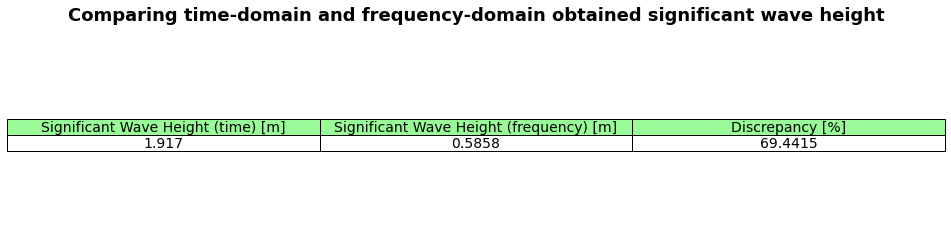

In [80]:
def plotSignificantHeightComparisonTable(HsTime, HsFrequency, percentualDiscrepancy):
    '''Receives the significant wave height obtained in time-domain and in
    frequency domain and plots a table comparing them'''
    colLabels = ["Significant Wave Height (time) [m]", "Significant Wave Height (frequency) [m]", "Discrepancy [%]"]
    table = plt.table(
        colLabels = colLabels,
        cellText = [[round(val, 4) for val in [HsTime, HsFrequency, percentualDiscrepancy]]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="center")
    table.auto_set_font_size(False)
    table.scale(2.8, 1.3)
    table.set_fontsize(14)
    
    plt.title("Comparing time-domain and frequency-domain obtained significant wave height", fontweight="bold", fontsize=18)
    plt.axis("off")
    plt.show()

HsTimeDomain = downCrossingSignificantStats["significantHeight"] # We consider the down-crossing method to be more accurate
percentualDiscrepancy = 100*np.abs(HsTimeDomain - Hs) / HsTimeDomain

plotSignificantHeightComparisonTable(HsTimeDomain, Hs, percentualDiscrepancy)

## 4.5 Comparing obtained Power Spectrum with Theoretical Spectral Model

--


In [35]:
def jonswapSpectrum(fs, Hs, Tp):
    D = 0.036-0.0056*Tp/np.sqrt(Hs)
    gama = np.exp(3.484*(1-0.1975*D*Tp**4/(Hs**2)))
    beta = (0.0624*(1.094-0.01915*np.log(gama)))/(0.23+0.0336*gama-0.185*(1.9+gama)**(-1))
    fp = 1/Tp
    def sigma(f): return 0.07 if f <= fp else 0.09
    def S(f):
        return beta*Hs**2*Tp**(-4)*f**(-5)*np.exp(-1.25*(Tp*f)**(-4))*gama**np.exp(-((Tp*f-1)**2)/2*sigma(f)**2)
    
    powerSpectralDensities = [S(f) for f in fs]
    return powerSpectralDensities

<ipython-input-35-f3b360744495>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return beta*Hs**2*Tp**(-4)*f**(-5)*np.exp(-1.25*(Tp*f)**(-4))*gama**np.exp(-((Tp*f-1)**2)/2*sigma(f)**2)
<ipython-input-35-f3b360744495>:8: RuntimeWarning: invalid value encountered in double_scalars
  return beta*Hs**2*Tp**(-4)*f**(-5)*np.exp(-1.25*(Tp*f)**(-4))*gama**np.exp(-((Tp*f-1)**2)/2*sigma(f)**2)


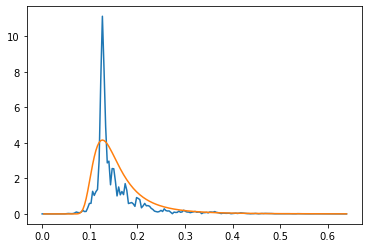

In [36]:
def plotJonsawpSpectrumComparison():
    PSDISSC = jonswapSpectrum(fsWelch, Hs=HsTimeDomain, Tp=Tp)
    plt.plot(fsWelch, PSDWelch)
    plt.plot(fsWelch, PSDISSC)
    plt.show()

    
plotJonsawpSpectrumComparison()

Sources:
1) https://www.usna.edu/NAOE/_files/documents/Courses/EN330/Rayleigh-Probability-Distribution-Applied-to-Random-Wave-Heights.pdf

2) https://www.usna.edu/NAOE/_files/documents/Courses/EN330/Random-Wave-Analysis.pdf

3) http://www.iopan.gda.pl/oceanologia/OC_40/OC40_3-4_Cieslikiewicz.pdf

4) https://upcommons.upc.edu/bitstream/handle/2099.1/6034/06.pdf?sequence=7

5) http://www.alekslabuda.com/sites/default/files/publications/[2016-03]%20Daniell%20method%20for%20PSD%20estimation%20in%20AFM.pdf

6) https://www.maths.lu.se/fileadmin/maths/personal_staff/Andreas_Jakobsson/StoicaM05.pdf

7) https://see.stanford.edu/materials/lsoftaee261/book-fall-07.pdf

8) https://www.alpharithms.com/autocorrelation-time-series-python-432909/

9) https://stackoverflow.com/questions/33973717/computing-a-power-spectrum

10) https://wikiwaves.org/Ocean-Wave_Spectra

11) https://fenix.tecnico.ulisboa.pt/downloadFile/845043405556530/MSW9%20-%20Modelling%20of%20Waves%20as%20a%20Random%20Ocean%20Process.pdf

12) http://neumeier.perso.ch/matlab/waves.html